In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

student-mat.csv
student-merge.R
student-por.csv



In [2]:
data_mat = pd.read_csv('../input/student-mat.csv')

**Characterizing the High School Relationship**

let's see the data columns

In [3]:
data_mat.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

note that a large portion of the data is not in the correct format (object columns). I will choose a subset of features to work with - address,studytime,failures,activities,nursery,higher,internet,famrel,freetime,absences,G3 

In [4]:
data_mat = data_mat[['address','studytime','failures','activities','nursery','higher','internet','famrel','freetime','absences','G3','romantic']]

let's transform the object columns into a workable format

In [5]:
binary_features = ['address','activities','nursery','higher','internet','romantic']
for column in binary_features:
    print(column,"-",data_mat[column].unique())

address - ['U' 'R']
activities - ['no' 'yes']
nursery - ['yes' 'no']
higher - ['yes' 'no']
internet - ['no' 'yes']
romantic - ['no' 'yes']


In [6]:
for column in binary_features:
    if (column == 'address'):
        data_mat[column] = data_mat[column].apply(lambda x: 1 if (x == 'U') else 0)
    else:
        data_mat[column] = data_mat[column].apply(lambda x: 1 if (x =='yes') else 0)
    print(column,"-",data_mat[column].unique())

address - [1 0]
activities - [0 1]
nursery - [1 0]
higher - [1 0]
internet - [0 1]
romantic - [0 1]


Great, now we can look at the Pearson correlation coefficents to find the most correlated features

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5]), <a list of 12 Text yticklabel objects>)

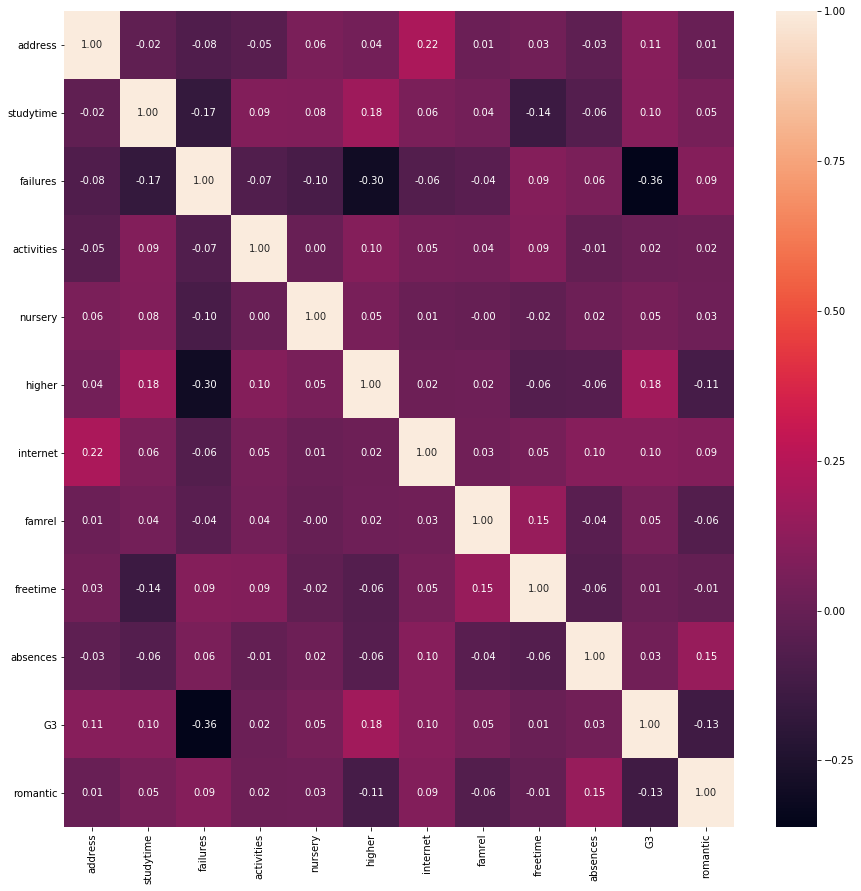

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(data_mat.corr(),annot = True,fmt = ".2f",cbar = True)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)

It seems like the address (living in an urban or rural environment) is barely correlated to being in a relationship for a highschool student. The same is true for activities (participating in extra-curricular activities) and nursery (attended nursery school). We will drop those columns together with the free time column (numerical variable describing the free time of a student) -

In [8]:
data_mat = data_mat[data_mat.columns.drop(['address','activities','nursery','freetime'])]

Let's look at the data, now with 7 features (besides the relationship status)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <a list of 8 Text yticklabel objects>)

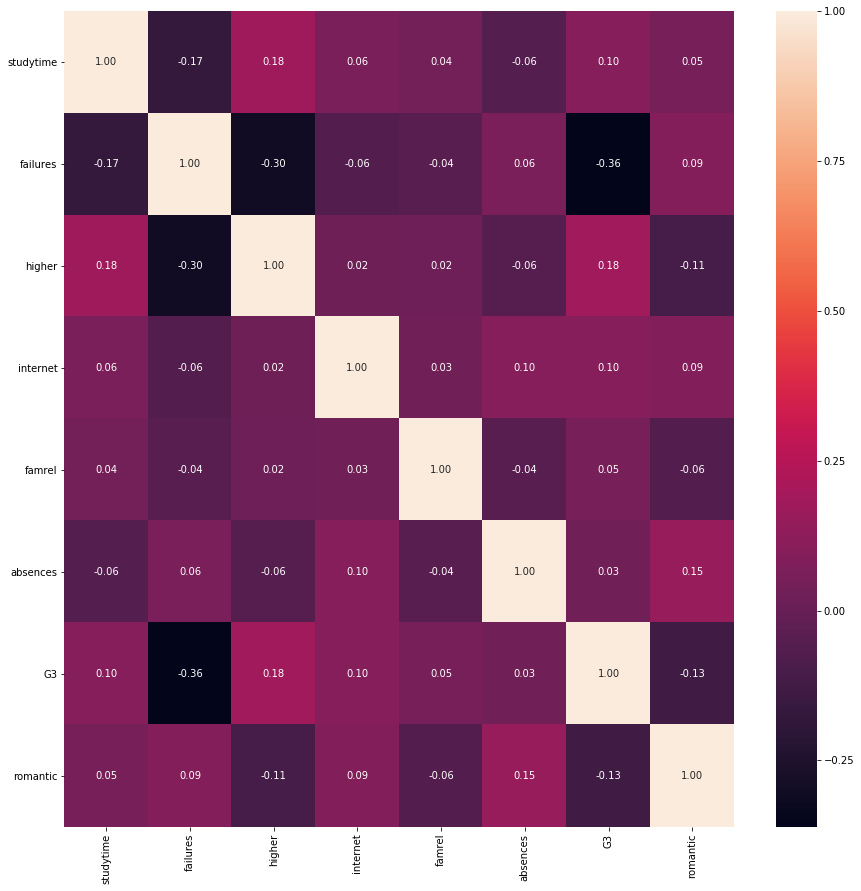

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(data_mat.corr(),annot = True,fmt = ".2f",cbar = True)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)

One can say that if a highschool student is in a relationship, he or she is among other things, less likely to attend his/her lectures, less likely to preform well on his/her exams, less likely to desire a higher education and more likely to have already failed the class.

**Decision Tree Prediction**

Lets see how well a decision tree might be able to make a prediction whether a high school student is in a relation based on the following 3 kinds of features - 2 binary features: higher and internet, 3 categorical features: absences, failures and studytime and 2 integer valued features: absences and G3

let's start by transform the categorical variables into a dummy indicator form

In [10]:
absences = pd.get_dummies(data_mat['absences'], drop_first = True)
failures = pd.get_dummies(data_mat['failures'],drop_first = True)
studytime = pd.get_dummies(data_mat['studytime'],drop_first = True)

data_mat.drop(['absences','failures','studytime'], axis =1, inplace = True)
data_mat = pd.concat([data_mat,absences, failures,studytime],axis = 1)
data_mat.head()

,higher,internet,famrel,G3,romantic,1,2,3,4,5,...,40,54,56,75,1,2,3,2,3,4
0,1,0,4,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,5,6,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,4,10,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1,1,3,15,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,4,10,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


next, we will split the data into labels and features

In [11]:
data_matf = data_mat.drop('romantic', axis = 1)
data_matl = data_mat['romantic']

in order to evaluate the performance of our predictor we will use 10 fold cross validation -  splitting the data into 10 folds, training the decision tree on 9 of them and evaluating its perforance on the  last fold, for each of the folds.

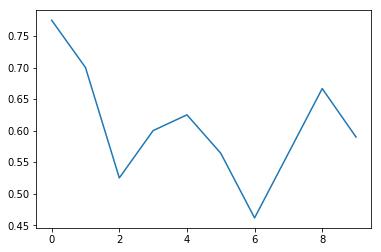

the average error is equal to  0.607115384615


In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

kf=KFold(n_splits=10, shuffle=True, random_state=False)
dtree = DecisionTreeClassifier()

outcomesDt = []
for train_id, test_id in kf.split(data_matf,data_matl):
    X_train, X_test = data_matf.values[train_id], data_matf.values[test_id]
    y_train, y_test = data_matl.values[train_id], data_matl.values[test_id]
    dtree.fit(X_train,y_train)
    predictions = dtree.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    outcomesDt.append(accuracy)
plt.plot(range(10),outcomesDt)
plt.show()
average_error_Dt = np.mean(outcomesDt)
print("the average error is equal to ",average_error_Dt)

Therefore, we will estimate the probability for error for a decision tree classifier to be {{average_error_Dt}}, regardless of the type of error (false negative and false postive are treated the same).

**Random Forest Prediction**

let's see whether a random forest performs better than a decision tree for the prediction we are interested at

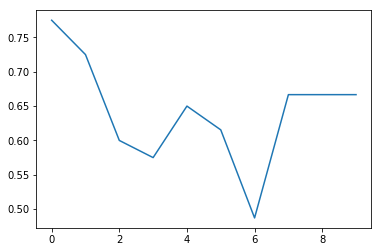

the average error is equal to  0.642756410256


In [13]:
from sklearn.ensemble import RandomForestClassifier
Rf=RandomForestClassifier(n_estimators=10)
outcomesRf=[]
for train_id, test_id in kf.split(data_matf,data_matl):
    X_train, X_test = data_matf.values[train_id], data_matf.values[test_id]
    y_train, y_test = data_matl.values[train_id], data_matl.values[test_id]
    Rf.fit(X_train,y_train)
    predictions = Rf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    outcomesRf.append(accuracy)
plt.plot(range(10),outcomesRf)
plt.show()
print("the average error is equal to ",np.mean(outcomesRf))

which means that an ensemble of 10 trees does not perform better than a single decision tree with respect to the probability of error. Let's see how the performance is dependent on the number of trees and attempt to decide which method makes a better decision with respect to the probability of error -

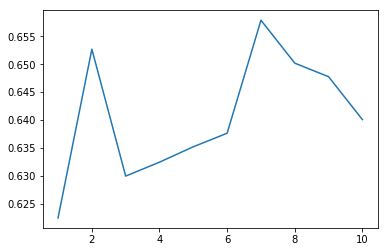

A decision tree works better than a random forest with respect to the probability error


In [14]:
ForestTreesPerformance = []
for n_trees in range(1,11,1):
    pRf=RandomForestClassifier(n_estimators=n_trees)
    outcomesRfs=[]
    for train_id, test_id in kf.split(data_matf,data_matl):
        X_train, X_test = data_matf.values[train_id], data_matf.values[test_id]
        y_train, y_test = data_matl.values[train_id], data_matl.values[test_id]
        Rf.fit(X_train,y_train)
        predictions = Rf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomesRfs.append(accuracy)
    ForestTreesPerformance.append(np.mean(outcomesRfs))
plt.plot(range(1,11,1),ForestTreesPerformance)
plt.show()
if (min(ForestTreesPerformance) > average_error_Dt):
    print("A decision tree works better than a random forest with respect to the probability error")
else:
    print("A random forest with",np.argmin(ForestTreesPerformance)+1,"trees works better than a decision tree with respect to the probability error")